In [1]:
from pathlib import Path
import tensorflow as tf
from tf_bodypix.api import download_model, load_model as _load_model, BodyPixModelPaths
import numpy as np
import json
from PIL.ImageFile import ImageFile
import logging
output_path = Path('./output')

logging.basicConfig(level='INFO')

_model = None


def get_model():
    global _model
    if _model is None:
        _model = _load_model(
            r'E:\adultbodypix\templates\3fe1b130a0f20e98340612c099b50c18-https-storage-googleapis-com-tfjs-models-savedmodel-bodypix-resnet50-float-model-stride16')

    return _model

In [2]:
bodypix_model = get_model()

In [3]:
output_path.mkdir(parents=True, exist_ok=True)

In [4]:
img_path = r'E:\git_my\bodypix-volume\static\main.jpg'
img = tf.keras.preprocessing.image.load_img(img_path)

In [6]:
image_array = tf.keras.preprocessing.image.img_to_array(img)
# get prediction result
peoples = bodypix_model.predict_single(image_array)
peoples

### PART_CHANNELS

默认身体标签名

In [7]:
from tf_bodypix.bodypix_js_utils.part_channels import PART_CHANNELS
for index, i in enumerate(PART_CHANNELS):
    print(index, i)

0 left_face
1 right_face
2 left_upper_arm_front
3 left_upper_arm_back
4 right_upper_arm_front
5 right_upper_arm_back
6 left_lower_arm_front
7 left_lower_arm_back
8 right_lower_arm_front
9 right_lower_arm_back
10 left_hand
11 right_hand
12 torso_front
13 torso_back
14 left_upper_leg_front
15 left_upper_leg_back
16 right_upper_leg_front
17 right_upper_leg_back
18 left_lower_leg_front
19 left_lower_leg_back
20 right_lower_leg_front
21 right_lower_leg_back
22 left_feet
23 right_feet


### RAINBOW_PART_COLORS

默认身体部位上色时的 rgb 数值

In [8]:
from tf_bodypix.bodypix_js_utils.output_rendering_util import (
    RAINBOW_PART_COLORS
)
for index, i in enumerate(RAINBOW_PART_COLORS):
    print(index, ':', i)

0 : (110, 64, 170)
1 : (143, 61, 178)
2 : (178, 60, 178)
3 : (210, 62, 167)
4 : (238, 67, 149)
5 : (255, 78, 125)
6 : (255, 94, 99)
7 : (255, 115, 75)
8 : (255, 140, 56)
9 : (239, 167, 47)
10 : (217, 194, 49)
11 : (194, 219, 64)
12 : (175, 240, 91)
13 : (135, 245, 87)
14 : (96, 247, 96)
15 : (64, 243, 115)
16 : (40, 234, 141)
17 : (28, 219, 169)
18 : (26, 199, 194)
19 : (33, 176, 213)
20 : (47, 150, 224)
21 : (65, 125, 224)
22 : (84, 101, 214)
23 : (99, 81, 195)


### get_scaled_segment_scores()  

获取归一化的身体\非身体张量  

越接近0表示与身体部位越不相关，即背景部分，越接近1表示越与身体部位相关。

In [9]:
segment_scores = peoples.get_scaled_segment_scores()
segment_scores[500, 500].numpy(), segment_scores[300, 600].numpy()

(array([0.9996306], dtype=float32), array([0.9994791], dtype=float32))

### get_mask(threshold)  

将身体\非身体部位进行二值化处理  
0 表示非人体的背景部分，1表示人体部位。是对 `get_scaled_segment_scores()` 返回值的后续处理，`threshold` 设置二值化处理的阈值。

In [10]:
mask = peoples.get_mask(threshold=0.5)

In [11]:
mask.shape, mask

(TensorShape([1920, 1200, 1]),
 <tf.Tensor: shape=(1920, 1200, 1), dtype=int32, numpy=
 array([[[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],
 
        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],
 
        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],
 
        ...,
 
        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],
 
        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],
 
        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]]])>)

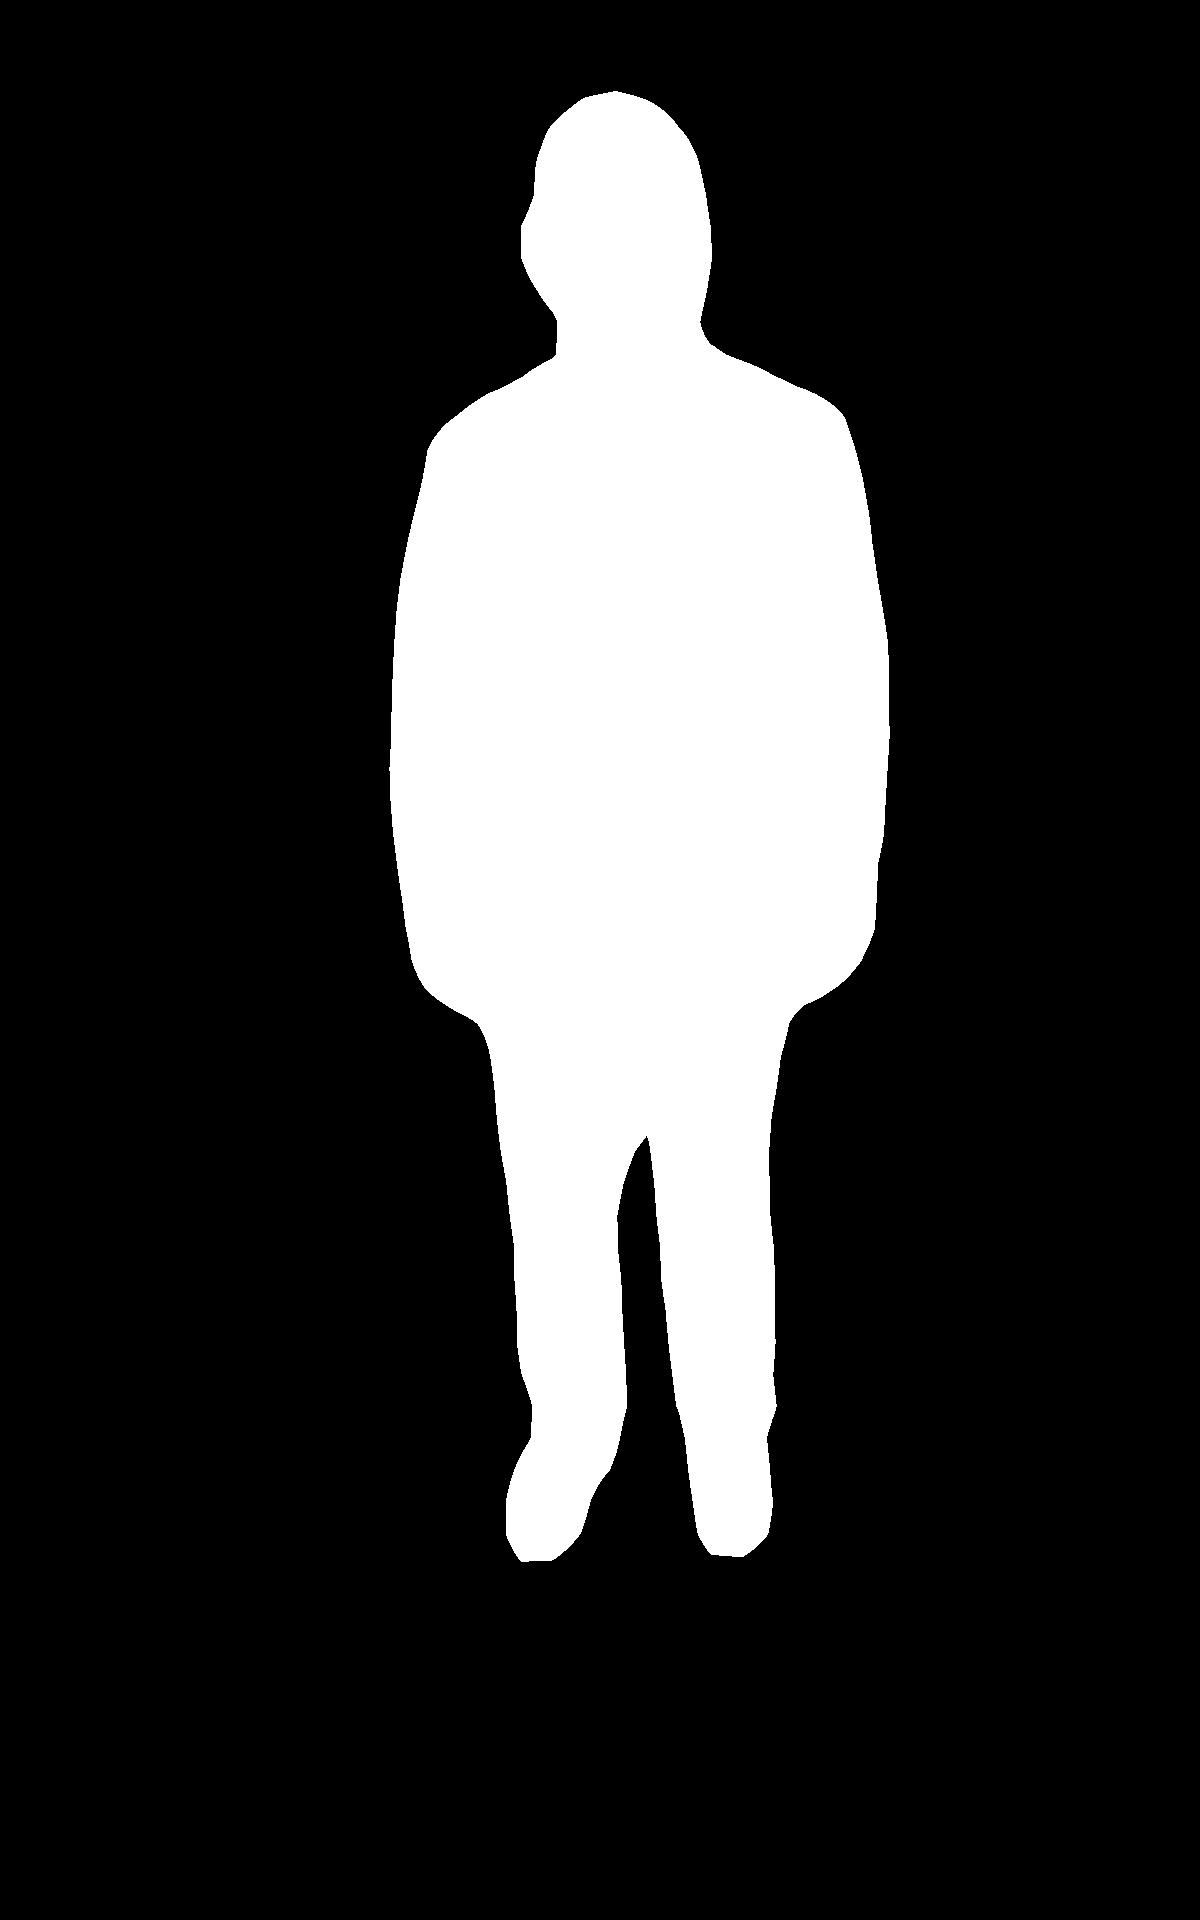

In [12]:
tf.keras.preprocessing.image.array_to_img(mask)

### get_scaled_part_heatmap_scores()

获取每个像素点对应身体各个部位的权重得分。  
总共将身体划分为24个部位，返回的结果shape是 `[height, width, 24]` 的，最后一维下标代表部位，数值表示对应部位的相似度，范围[0,1]，数值越大表示越与该部位相似。

In [13]:
scaled_part_scores = peoples.get_scaled_part_heatmap_scores()

🙃不知为何非人体的背景部分被预测为12(前躯干)

In [14]:
point = scaled_part_scores[0, 0]
print(point)
print(np.argmax(point, axis=-1))  # 取数组最后一维的最大值下标

tf.Tensor(
[0.6601771  0.69974166 0.68346673 0.17865089 0.6679785  0.21879122
 0.6769981  0.50250334 0.9380485  0.38972527 0.20938441 0.6452816
 0.99260885 0.9198272  0.95081455 0.55208135 0.7201315  0.5156409
 0.29898703 0.4638726  0.52181494 0.10677594 0.42706156 0.49859652], shape=(24,), dtype=float32)
12


### get_scaled_part_segmentation(mask=None, part_names=None) 

获取每个像素点按照权重映射为身体部位标签，默认标签就是0-23。

即在前面 `get_scaled_part_heatmap_scores()` 方法返回的结果上进一步处理，用`np.argmax` 计算全部像素点对应的身体部位最大权重下标，再映射为身体标签

- mask 二值化蒙版，可选
- part_names：字符串列表，表示只保留指定的身体部位，具体值从 `PART_CHANNELS` 中取，默认不过滤身体部位

In [15]:
scaled_part = peoples.get_scaled_part_segmentation()

In [16]:
scaled_part.shape, scaled_part

((1920, 1200),
 array([[12, 12, 12, ..., 12, 12, 12],
        [12, 12, 12, ..., 12, 12, 12],
        [12, 12, 12, ..., 12, 12, 12],
        ...,
        [13, 13, 13, ..., 13, 13, 13],
        [13, 13, 13, ..., 13, 13, 13],
        [13, 13, 13, ..., 13, 13, 13]], dtype=int64))

### get_part_mask(mask, part_names=None)

筛选给定的`part_names`部位的蒙版，默认全部身体部位，具体值从 `PART_CHANNELS` 中取，当`part_names`为`None`时，返回值就是 `mask` 参数


In [17]:
part_filter = ['left_face', 'right_face', 'right_upper_arm_front',
               'left_upper_arm_front', 'left_upper_leg_front']
part_mask = peoples.get_part_mask(mask, part_names=part_filter)
part_mask

array([[[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       ...,

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]]])

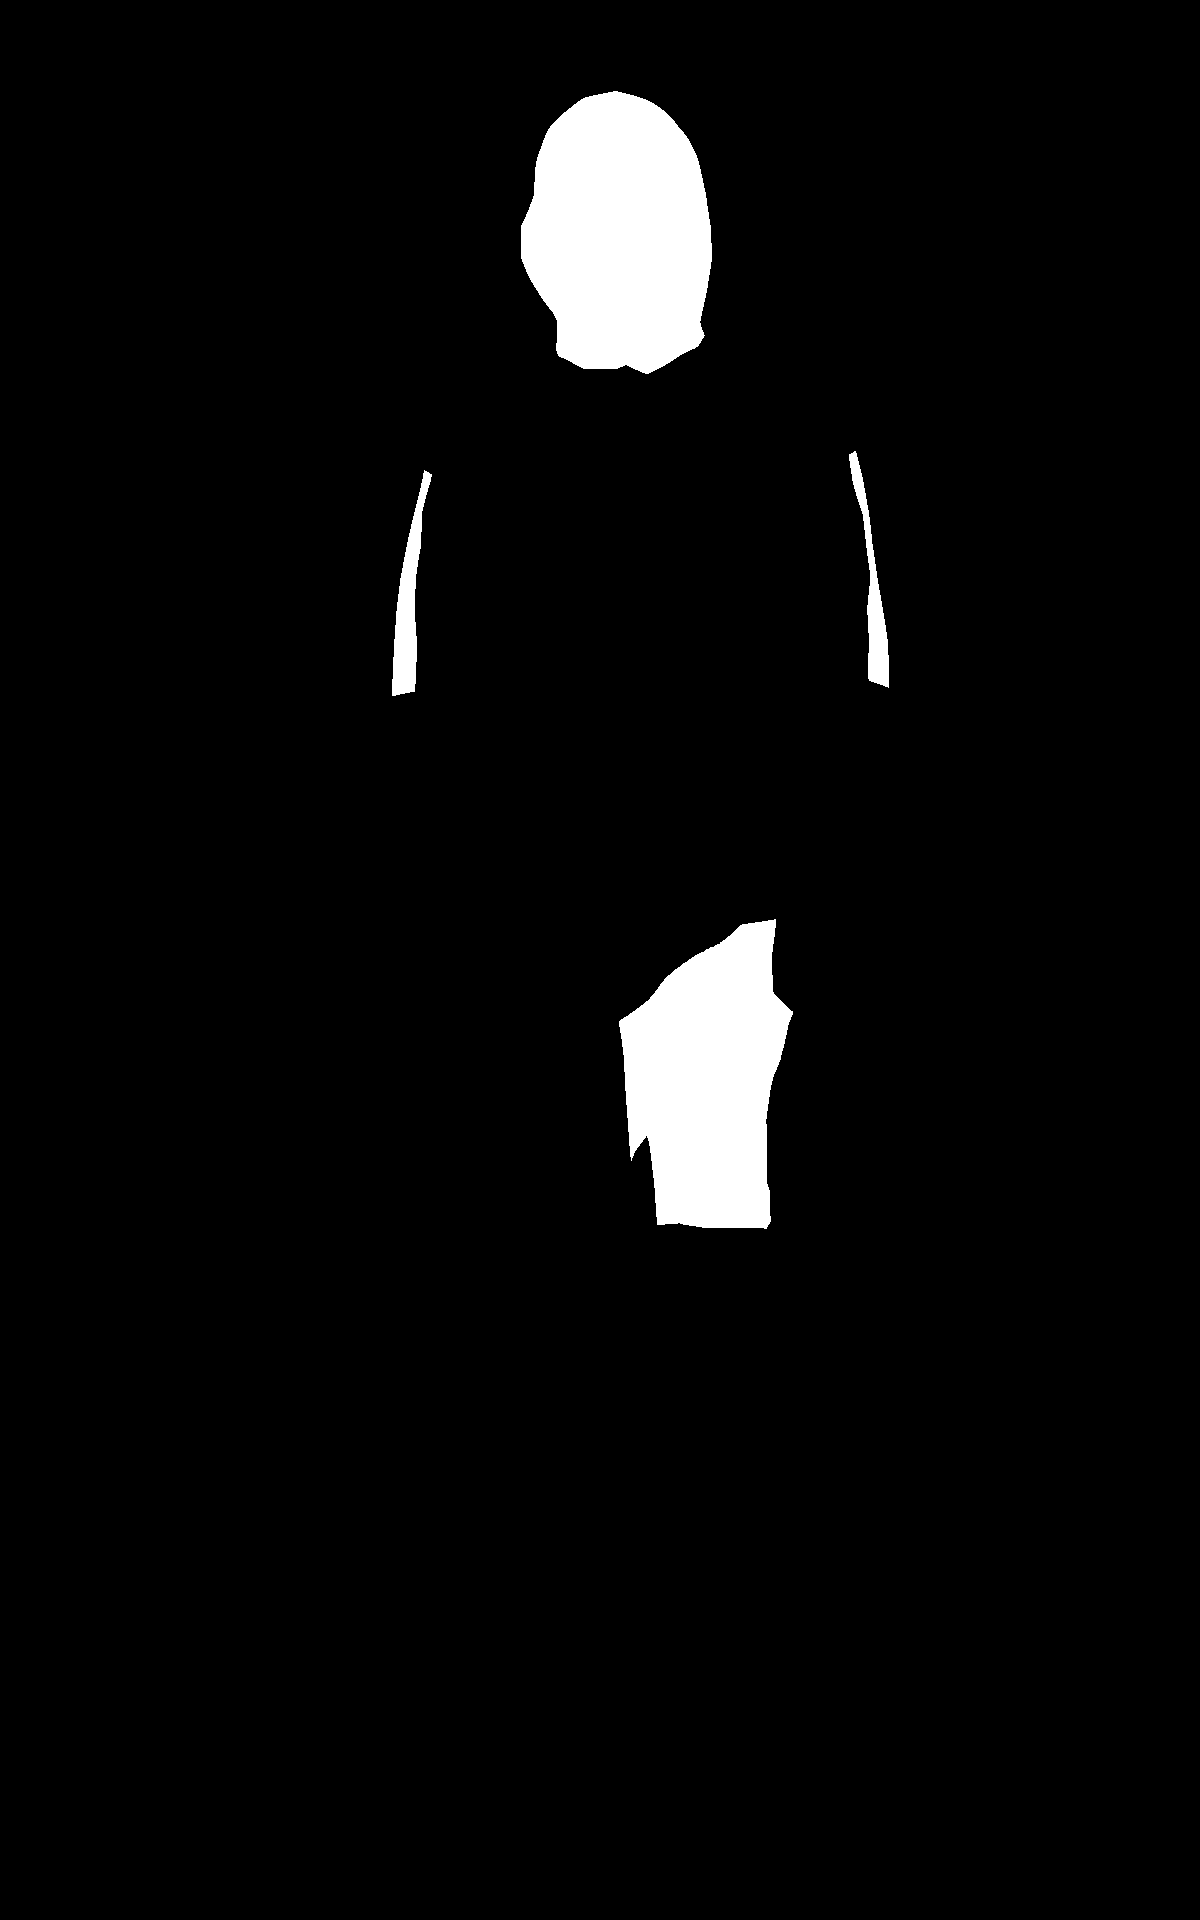

In [18]:
tf.keras.preprocessing.image.array_to_img(part_mask)

### get_colored_part_mask(mask, part_colors=None, part_names=None)

给身体不同部位上色并返回处理后的蒙版。  

非身体部位颜色为(0,0,0)，但是该参数未提供给用户输入，况且有mask蒙版参数限制，非身体部位只能是(0,0,0)的黑色了

- part_colors：自定义身体24个部位的rgb颜色，默认为 `RAINBOW_PART_COLORS`
- part_names：筛选给定的part_names部位列表



In [19]:
colored_mask = peoples.get_colored_part_mask(mask)
colored_mask

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]])

In [20]:
colored_mask[500, 500], colored_mask[300, 600]

(array([175, 240,  91]), array([143,  61, 178]))

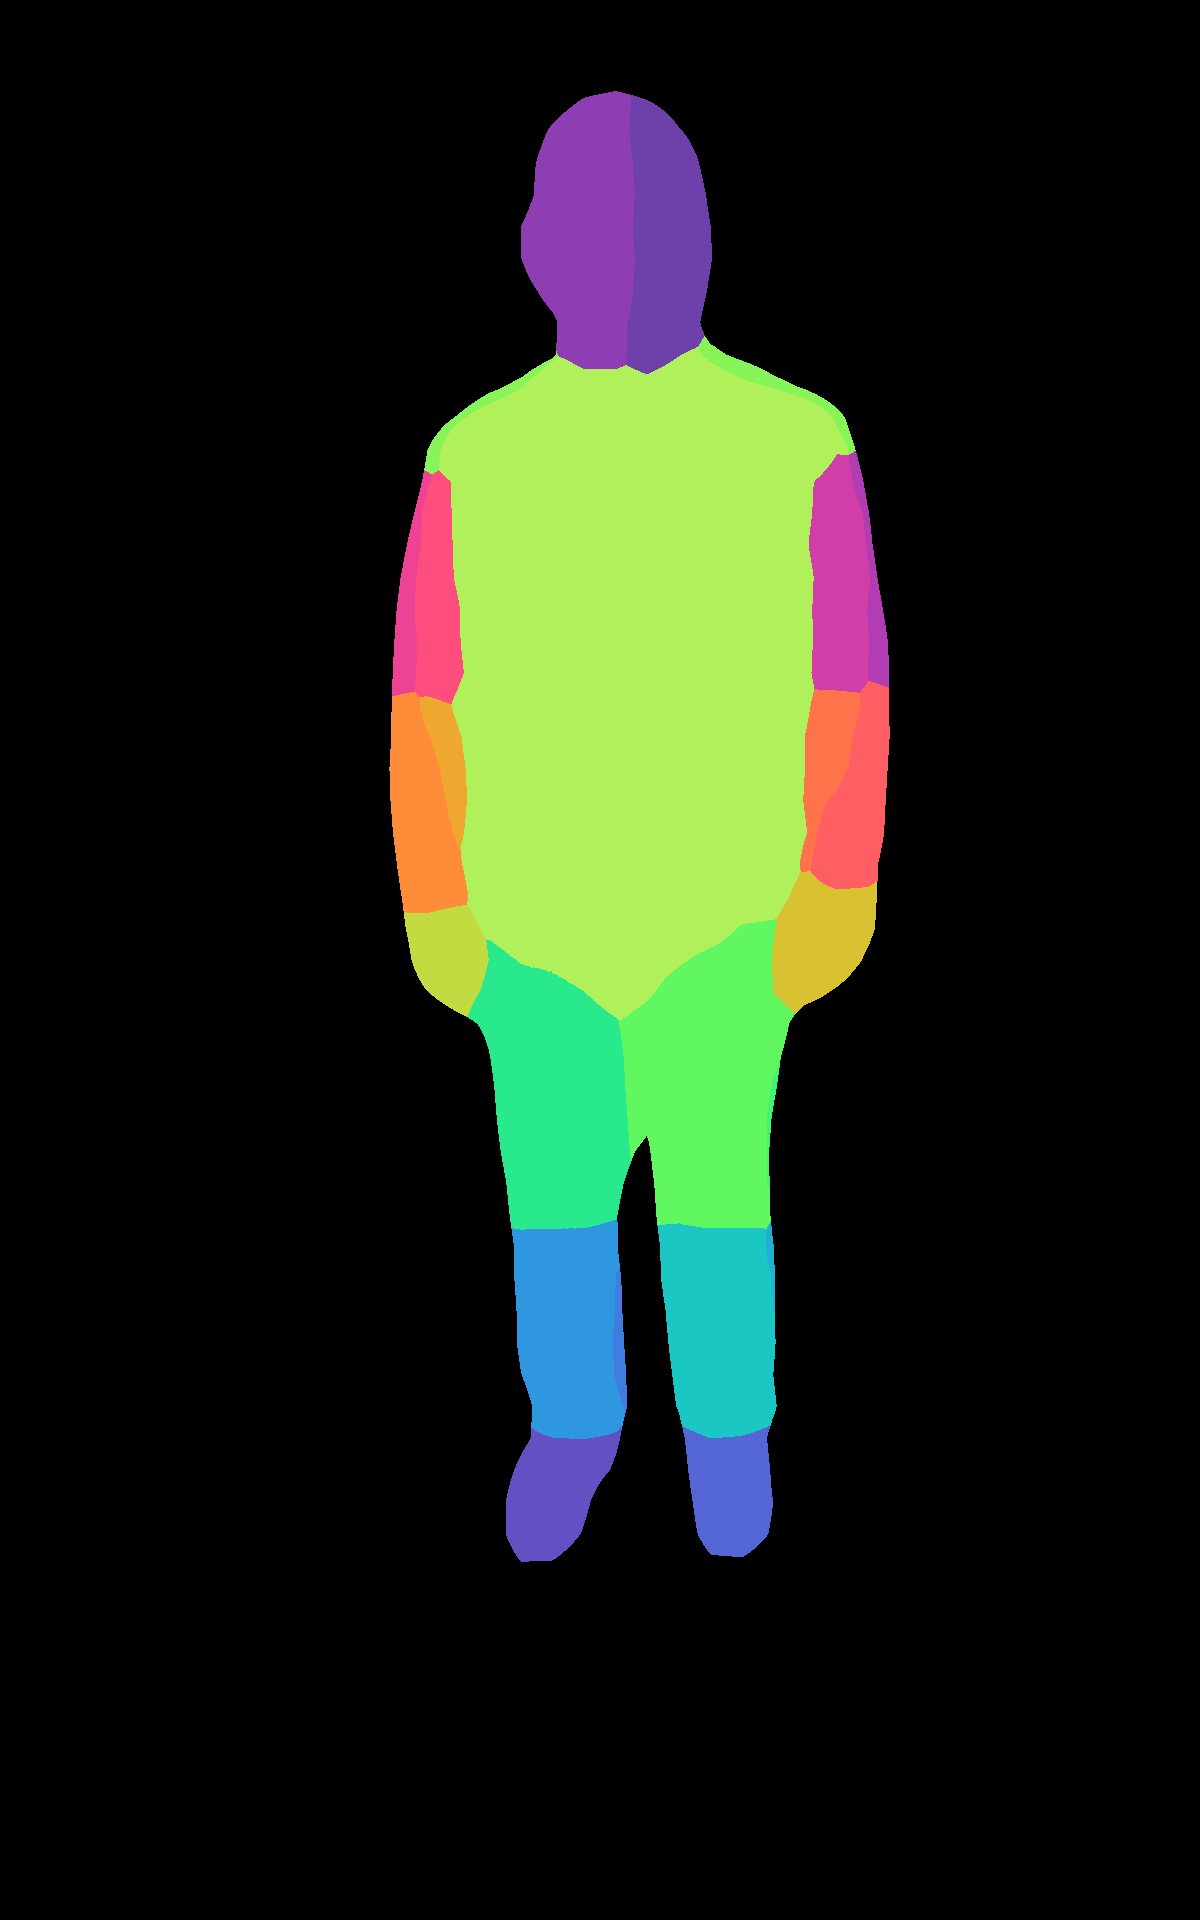

In [21]:
tf.keras.preprocessing.image.array_to_img(colored_mask)

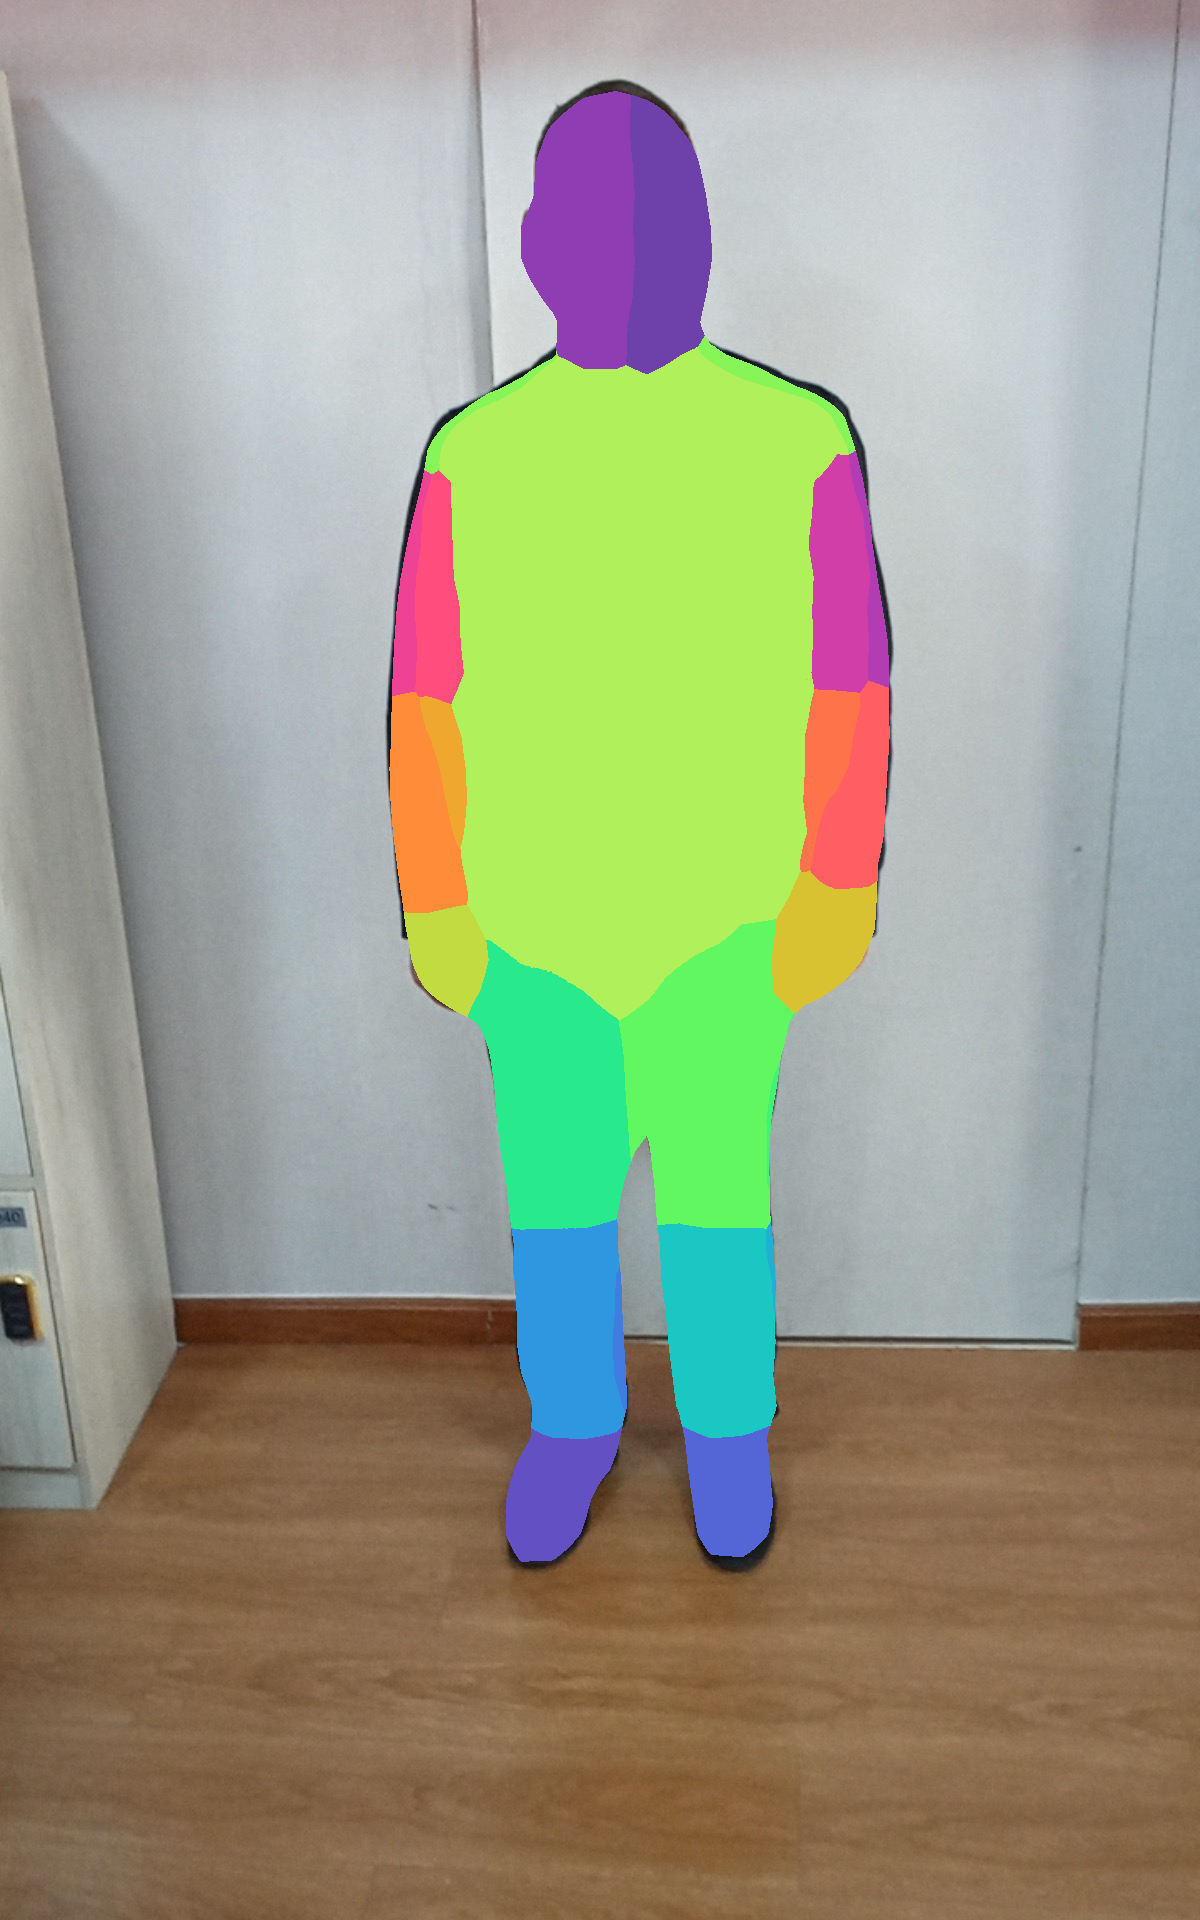

In [22]:
colored_mask_with_raw_image = np.where(mask > 0, colored_mask, image_array)
tf.keras.preprocessing.image.array_to_img(colored_mask_with_raw_image)

### get_poses() 

获取肢体姿态

In [27]:
# poses
from tf_bodypix.draw import draw_poses  # utility function using OpenCV

poses = peoples.get_poses()
image_with_poses = draw_poses(
    colored_mask_with_raw_image.copy(),  # create a copy to ensure we are not modifing the source image
    poses,
    keypoints_color=(255, 100, 100),
    skeleton_color=(100, 100, 255)
)

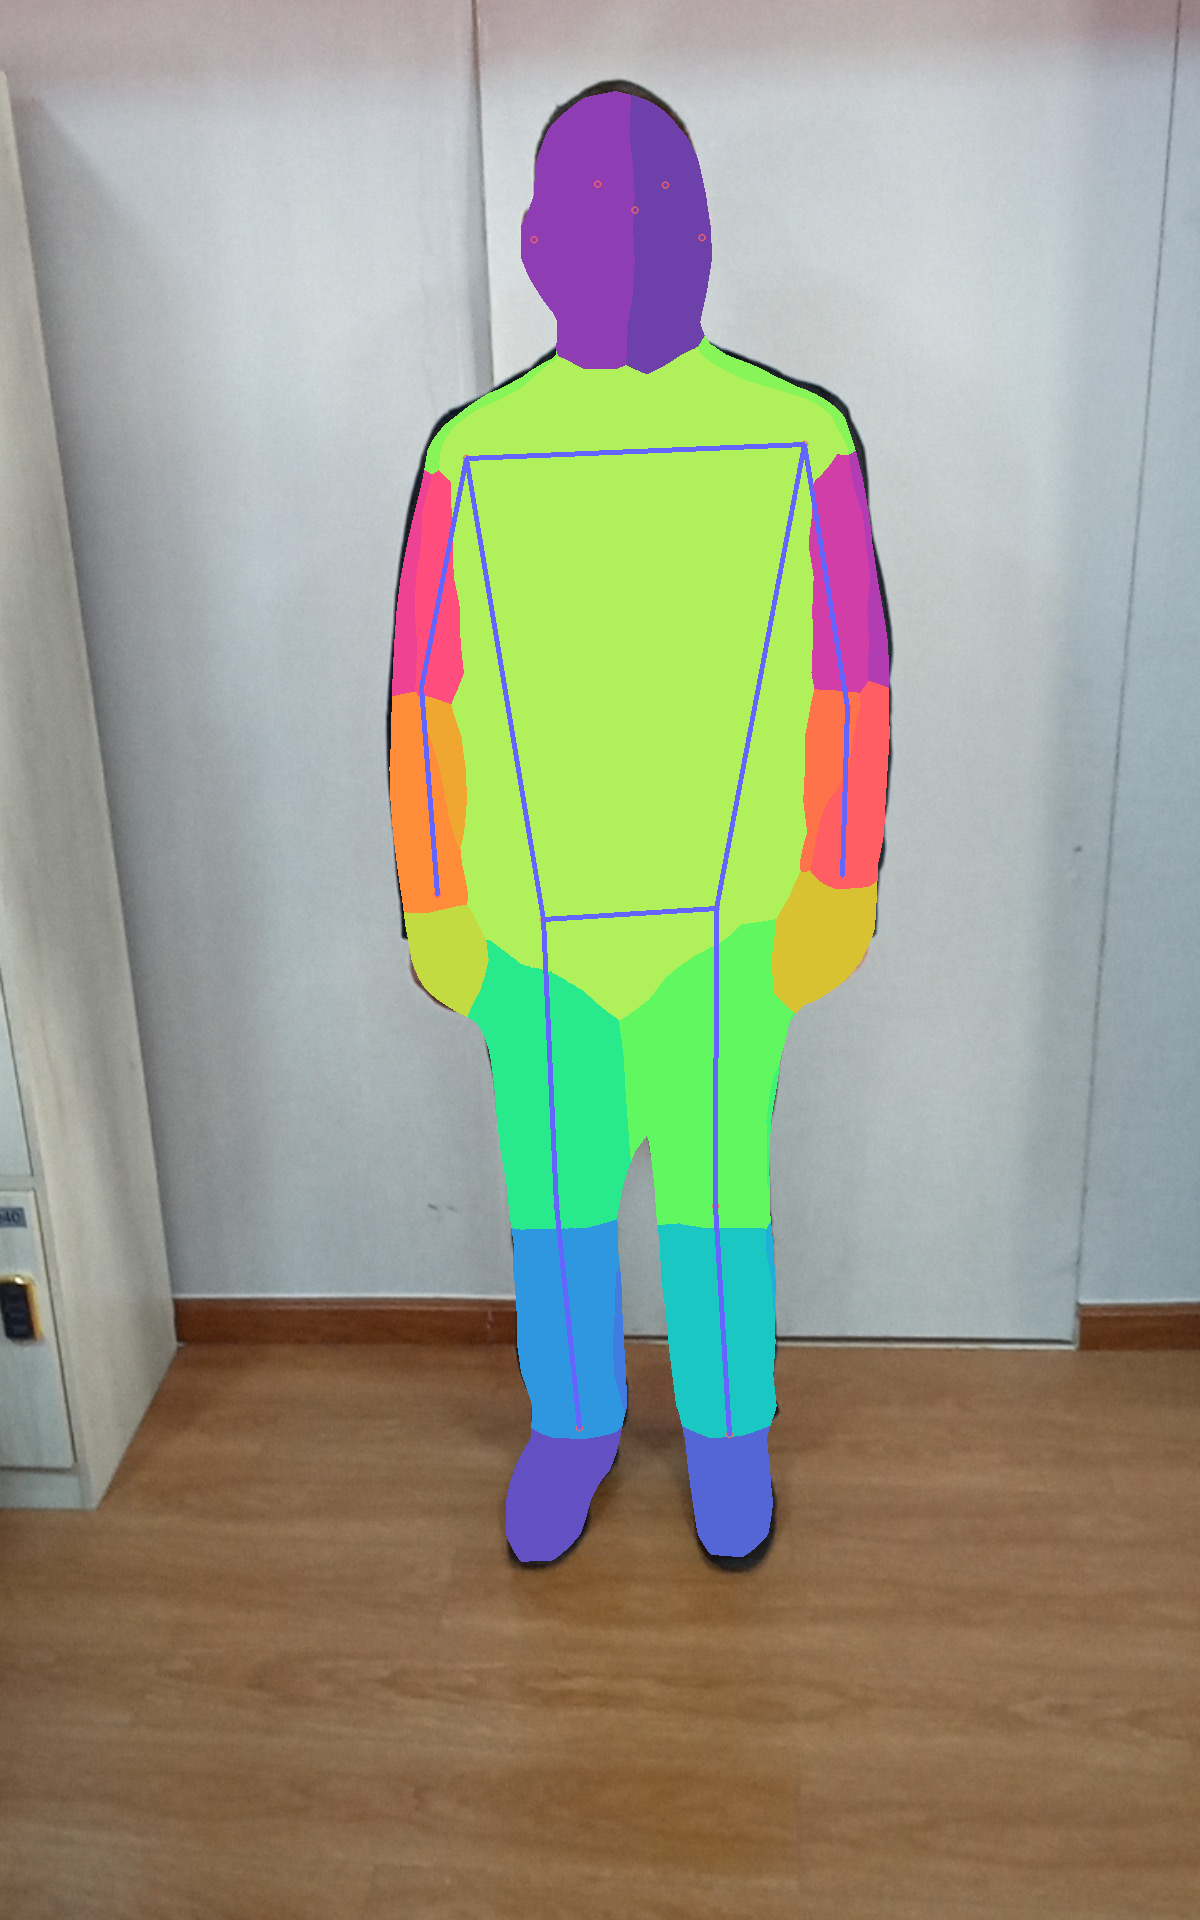

In [28]:
tf.keras.preprocessing.image.array_to_img(image_with_poses)